In [1]:
%cd /workdir/hdd29/chloroplast_genome_evaluation

/local/workdir/hdd29/chloroplast_genome_evaluation


In [2]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import re 
from tqdm import tqdm
import seaborn as sns
from Bio import SeqIO
from Bio import SeqUtils
import numpy as np
import glob
from Bio.Data import CodonTable
from collections import defaultdict, Counter
from pandarallel import pandarallel
from scipy.stats import pearsonr


pandarallel.initialize()


INFO: Pandarallel will run on 44 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# --- config ---
in_fa = "data/tmp/rbcL_aln/rbcL_pal2nal.fa"     # codon-aware DNA alignment
out_masked = "data/aligned_cds.4D.masked.fasta"
out_strict = "data/aligned_cds.4D.strict.fasta"
out_sites = "data/aligned_cds.4D.sites.tsv"
genetic_code = 11  # 1 for Standard, 11 for Bacterial/Archaeal/Plant Plastid
mode = "strict"    # "strict" or "per_taxon"
mask_char = "N"

fourfold_prefixes = { "GC","CG","CC","GG","CT","TC","GT","AC" }


In [4]:
records = list(SeqIO.parse(in_fa, "fasta"))
L = len(records[0].seq)
assert all(len(r.seq)==L for r in records), "All sequences must have same length"
assert L % 3 == 0, "Alignment length must be a multiple of 3"


In [5]:
def is_unambiguous_codon(c):
    return set(c.upper()) <= set("ACGT")

# Precompute which codon indices are 4D per taxon
per_taxon_4d = [set() for _ in records]  # set of codon indices (0..ncodons-1)
stop_codons = set(CodonTable.unambiguous_dna_by_id[genetic_code].stop_codons)

ncod = L // 3

In [6]:
for i, rec in tqdm(enumerate(records)):
    s = str(rec.seq).upper()
    for k in range(ncod):
        codon = s[3*k:3*k+3]
        if "-" in codon or not is_unambiguous_codon(codon):
            continue
        if codon in stop_codons:
            continue
        if codon[:2] in fourfold_prefixes:
            per_taxon_4d[i].add(k)

15255it [00:06, 2342.39it/s]


In [7]:
valid_k = []
codon_distributions = {}  # store codon counts per site
prefix_distributions = {}

for k in tqdm(range(ncod)):
    codons_here = []
    for rec in records:
        codon = str(rec.seq[3*k:3*k+3]).upper()
        if ("-" in codon) or (not is_unambiguous_codon(codon)) or (codon in stop_codons):
            continue
        codons_here.append(codon)
    
    if not codons_here:
        continue
    
    # Count codons and prefixes
    codon_counts = Counter(codons_here)
    prefix_counts = Counter(c[:2] for c in codons_here)
    
    # Majority prefix
    prefix, count = prefix_counts.most_common(1)[0]
    freq = count / sum(prefix_counts.values())
    
    codon_distributions[k] = codon_counts
    prefix_distributions[k] = prefix_counts
    
    #95% consensus gives 207 sites
    if prefix in fourfold_prefixes and freq >= 0.99:
        valid_k.append((k, prefix))

print(f"Relaxed 4-fold codons (95% consensus): {len(valid_k)}")

# Example: show distribution at one site
site = valid_k[0]

100%|██████████| 701/701 [00:14<00:00, 49.85it/s]

Relaxed 4-fold codons (95% consensus): 207


In [8]:
masked_records = []
gc_summary = []

for rec in tqdm(records):
    s = list(str(rec.seq).upper())
    counts = Counter()

    for k in range(ncod):  # iterate over codons
        codon = "".join(s[3*k:3*k+3])

        # skip ambiguous/gap/stop codons
        if "-" in codon or not is_unambiguous_codon(codon) or codon in stop_codons:
            s[3*k:3*k+3] = ["N"]*3
            continue

        # check if codon is valid 4D site
        valid_prefix = next((prefix for vk, prefix in valid_k if k == vk), None)

        if valid_prefix and codon[:2] == valid_prefix:
            # keep only 3rd base
            base3 = codon[2]
            s[3*k:3*k+2] = ["N","N"]
            s[3*k+2] = base3
            if base3 in "ACGT":
                counts[base3] += 1
        else:
            # mask non-4D or deviant codon
            s[3*k:3*k+3] = ["N"]*3

    # update sequence with masked bases
    rec.seq = rec.seq.__class__("".join(s))
    masked_records.append(rec)

    # compute GC summaries
    total = counts["A"] + counts["T"] + counts["G"] + counts["C"]
    gc_summary.append({
        "taxon": rec.id,
        "rbcL_nuc_G": counts["G"],
        "rbcL_nuc_C": counts["C"],
        "rbcL_nuc_A": counts["A"],
        "rbcL_nuc_T": counts["T"],
        "GC_content": (counts["G"] + counts["C"]) / total if total > 0 else None
    })

# Save masked alignment
SeqIO.write(masked_records, "data/tmp/rbcL_aln/aligned_cds.4D.masked.fasta", "fasta")

# Save GC summary
df_gc = pd.DataFrame(gc_summary)
df_gc.to_csv("data/tmp/rbcL_aln/gc_summary_per_taxon.tsv", sep="\t", index=False)

print("Outputs written: masked FASTA + GC summary table")

100%|██████████| 15255/15255 [00:45<00:00, 336.17it/s]


Outputs written: masked FASTA + GC summary table


In [ ]:
#checkpoint 1

In [9]:
#now, let's correlate with the degenerateGC calculated from my other method
old_method_df = pd.read_csv("data/data_with_pheno.csv")
print(f"Old Method DataFrame shape: {old_method_df.shape}")
new_df = pd.read_csv("data/tmp/rbcL_aln/gc_summary_per_taxon.tsv", sep="\t")
print(f"New DataFrame shape: {new_df.shape}")

#make the ID column by seperating taxon on "|" and keeping the first part
new_df["ID"] = new_df["taxon"].apply(lambda x: x.split("|")[0])
#rename the GC_content column to be GC_content_99_consensus
new_df.rename(columns={"GC_content": "GC_content_99_consensus"}, inplace=True)

#left join, keeping only rows in new_df
merged_df = pd.merge(new_df, old_method_df, on="ID", how="left")
#print shape
print(f"Merged DataFrame shape: {merged_df.shape}")

/tmp/ipykernel_212642/3417185678.py:2: DtypeWarning: Columns (378,390,410) have mixed types. Specify dtype option on import or set low_memory=False.
  old_method_df = pd.read_csv("data/data_with_pheno.csv")


Old Method DataFrame shape: (15286, 596)
New DataFrame shape: (15255, 6)
Merged DataFrame shape: (15255, 602)


In [10]:
#read in the peptide alignment, and count how many times each amino acid appears
aa_fasta = "data/tmp/rbcL_aln/rbcL_AA.fasta"
# do this on the header to get the ID, then merge it to the old dataframe
#.apply(lambda x: x.split("|")[0])

# Step 1: Parse FASTA and count amino acids
aa_counts = []
for record in tqdm(SeqIO.parse(aa_fasta, "fasta")):
    seq_id = record.id.split("|")[0]   # adjust if ID parsing differs
    seq_str = str(record.seq)

    # count amino acids
    counts = {aa: seq_str.count(aa) for aa in set(seq_str)}
    counts["ID"] = seq_id
    aa_counts.append(counts)

# Step 2: Make dataframe
aa_df = pd.DataFrame(aa_counts).fillna(0)
print(f"Amino acid counts DataFrame shape: {aa_df.shape}")

# Step 3: Merge with your old dataframe
merged_df = merged_df.merge(aa_df, left_on="ID", right_on="ID", how="left")

print(merged_df.head())

15255it [00:00, 35692.39it/s]


Amino acid counts DataFrame shape: (15255, 24)
                                      taxon  rbcL_nuc_G  rbcL_nuc_C  \
0  PX058852.1|Gene_rbcL|Taxonomy:Eukaryota;          23          19   
1  PX058851.1|Gene_rbcL|Taxonomy:Eukaryota;          25          17   
2  PX058850.1|Gene_rbcL|Taxonomy:Eukaryota;          23          19   
3  PX057650.1|Gene_rbcL|Taxonomy:Eukaryota;          22          21   
4  PP175340.1|Gene_rbcL|Taxonomy:Eukaryota;          21          23   

   rbcL_nuc_A  rbcL_nuc_T  GC_content_99_consensus          ID FileBasename  \
0          48          81                 0.245614  PX058852.1    PX0588521   
1          47          82                 0.245614  PX058851.1    PX0588511   
2          48          81                 0.245614  PX058850.1    PX0588501   
3          41          85                 0.254438  PX057650.1    PX0576501   
4          40          85                 0.260355  PP175340.1    PP1753401   

                              Organism  \
0        

In [11]:
#write the file out
merged_df.to_csv("data/tmp/rbcL_aln/merged_aa_counts.csv", index=False)

In [12]:
#print summary statistics of the two GC content columns
print("Summary statistics for GC_content_99_consensus:")
print(merged_df["GC_content_99_consensus"].describe())
print("Summary statistics for rbcL_degenerate_GC:")
print(merged_df["rbcL_degenerate_GC"].describe())

Summary statistics for GC_content_99_consensus:
count    15254.000000
mean         0.451030
std          0.059220
min          0.216216
25%          0.413793
50%          0.450000
75%          0.488372
max          0.677419
Name: GC_content_99_consensus, dtype: float64
Summary statistics for rbcL_degenerate_GC:
count    15251.000000
mean         0.230624
std          0.026933
min          0.129187
25%          0.215311
50%          0.229268
75%          0.246377
max          0.394595
Name: rbcL_degenerate_GC, dtype: float64


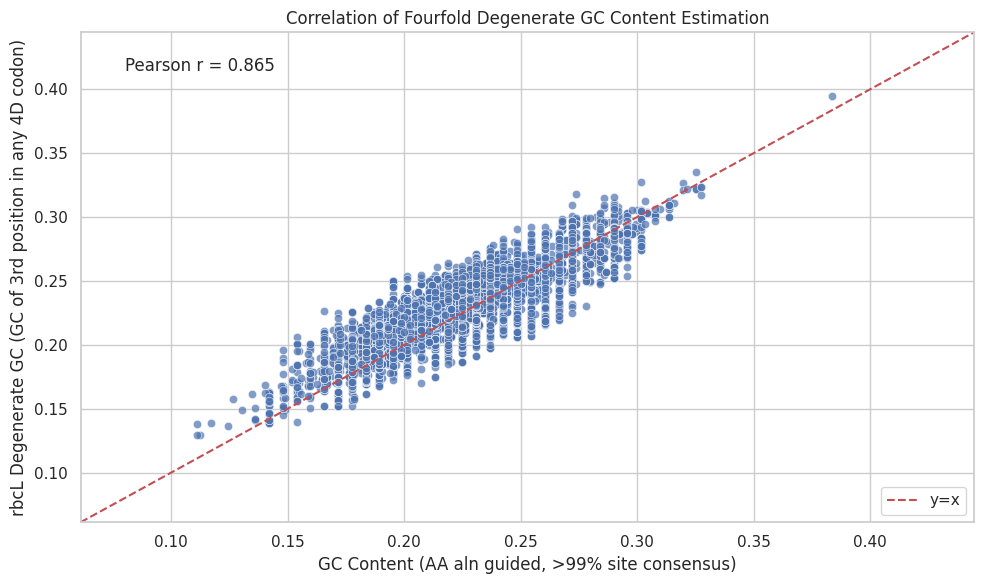

In [35]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# scatter plot
sns.scatterplot(data=merged_df, x="GC_content_99_consensus", y="rbcL_degenerate_GC", alpha=0.7)

# add y=x line
lims = [
    min(merged_df["GC_content_99_consensus"].min()-0.05, merged_df["rbcL_degenerate_GC"].min()-0.05),
    max(merged_df["GC_content_99_consensus"].max()+0.05, merged_df["rbcL_degenerate_GC"].max()+0.05)
]
plt.plot(lims, lims, 'r--', label="y=x")  # dashed red line
plt.xlim(lims)
plt.ylim(lims)

# compute Pearson correlation
valid = merged_df[["GC_content_99_consensus", "rbcL_degenerate_GC"]].dropna()

corr, pval = pearsonr(valid["GC_content_99_consensus"], valid["rbcL_degenerate_GC"])
plt.text(0.05, 0.95, f"Pearson r = {corr:.3f}", transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=12)

plt.title("Correlation of Fourfold Degenerate GC Content Estimation")
plt.xlabel("GC Content (AA aln guided, >99% site consensus)")
plt.ylabel("rbcL Degenerate GC (GC of 3rd position in any 4D codon)")
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
corr

np.float64(nan)

In [6]:
#what's the correlation?
correlation = merged_df["GC_content_99_consensus"].corr(merged_df["rbcL_degenerate_GC"])
print(f"Correlation between GC_content_99_consensus and rbcL_degenerate_GC: {correlation:.4f}")

Correlation between GC_content_99_consensus and rbcL_degenerate_GC: 0.8653


In [10]:
#what's the point with the highest GC_content_99_consensus?
max_gc_row = merged_df.loc[merged_df["GC_content_99_consensus"].idxmax()]
print(f"Point with highest GC_content_99_consensus: {max_gc_row['ID']} with GC content {max_gc_row['GC_content_99_consensus']:.4f}")
#print his taxonomy

print(f"Taxonomy: {max_gc_row['Organism']}")

Point with highest GC_content_99_consensus: MZ475300.1 with GC content 0.3838
Taxonomy: Ziziphus hajarensis


In [14]:
#the Order column is to be derived by splitting taxonomy on ;
# and finding the term that ends in "ales".

merged_df["Order"] = merged_df["Taxonomy"].apply(lambda x: next((part for part in x.split(";") if part.strip().endswith("ales")), None))
#table of counts of Orders
order_counts = merged_df["Order"].value_counts()
print("Counts of Orders in the dataset:")
print(order_counts)

Counts of Orders in the dataset:
Order
Lamiales            1448
Poales              1340
Rosales             1258
Asparagales         1100
Asterales            946
Fabales              729
Ranunculales         696
Ericales             674
Malpighiales         547
Caryophyllales       483
Apiales              473
Saxifragales         467
Brassicales          431
Myrtales             415
Sapindales           408
Solanales            391
Fagales              328
Gentianales          325
Laurales             259
Malvales             249
Liliales             194
Dipsacales           182
Zingiberales         167
Cucurbitales         119
Cornales             119
Vitales              112
Aquifoliales         103
Pinales               99
Cupressales           98
Santalales            92
Celastrales           84
Boraginales           76
Commelinales          67
Dioscoreales          55
Magnoliales           48
Piperales             37
Oxalidales            30
Austrobaileyales      28
Araucariale

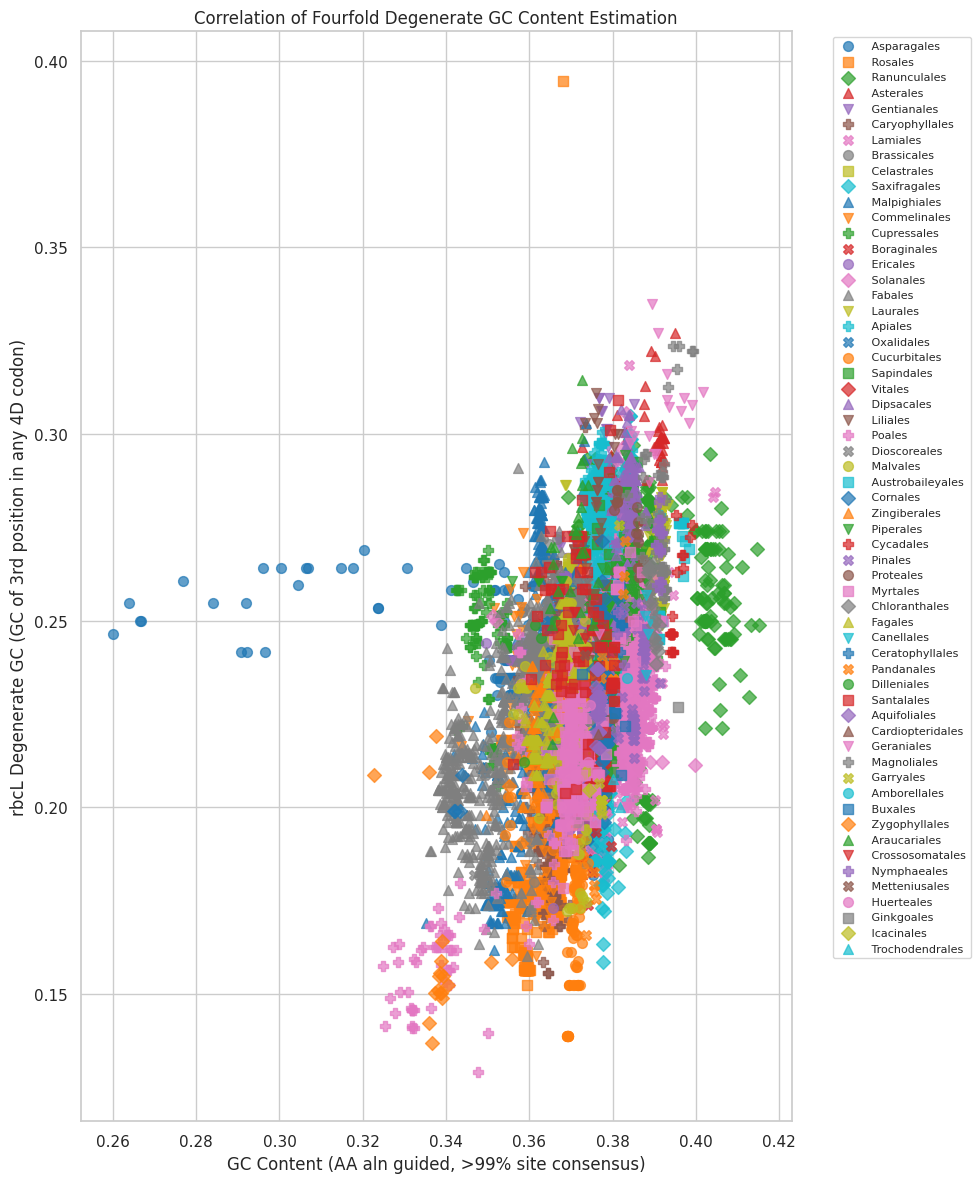

In [18]:
# define small set of distinct colors and markers
colors = sns.color_palette("tab10")  # 10 colors
markers = ["o", "s", "D", "^", "v", "P", "X"]  # 7 marker shapes

# get unique orders
orders = merged_df["Order"].unique()
n_orders = len(orders)

# assign a color and marker to each order cyclically
order_color = {order: colors[i % len(colors)] for i, order in enumerate(orders)}
order_marker = {order: markers[i % len(markers)] for i, order in enumerate(orders)}

# plot
plt.figure(figsize=(10, 12))

for order in orders:
    subset = merged_df[merged_df["Order"] == order]
    plt.scatter(
        subset["genomicGC"], subset["rbcL_degenerate_GC"],
        color=order_color[order],
        marker=order_marker[order],
        alpha=0.7,
        label=order,
        s=50  # adjust marker size
    )

plt.xlabel("GC Content (AA aln guided, >99% site consensus)")
plt.ylabel("rbcL Degenerate GC (GC of 3rd position in any 4D codon)")
plt.title("Correlation of Fourfold Degenerate GC Content Estimation")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

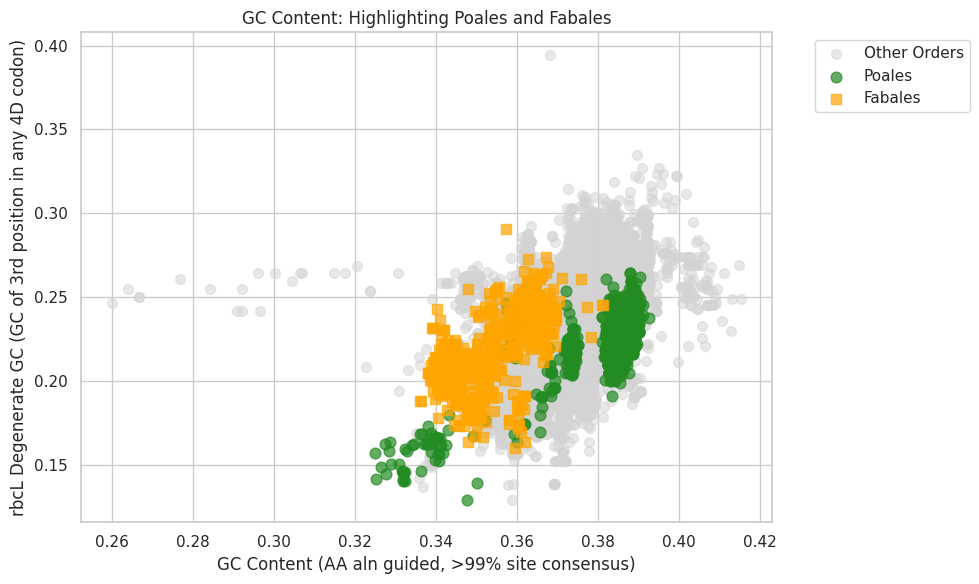

In [23]:
highlight_colors = {"Poales": "forestgreen", "Fabales": "orange"}
highlight_markers = {"Poales": "o", "Fabales": "s"}

plt.figure(figsize=(10, 6))
merged_df["Order"] = merged_df["Order"].str.strip().str.capitalize()


# plot all other orders in light grey
other = merged_df[~merged_df["Order"].isin(highlight_colors.keys())]
plt.scatter(other["genomicGC"], other["rbcL_degenerate_GC"],
            color="lightgrey", alpha=0.5, s=50, label="Other Orders")

# overlay Poales and Fabales
for order in highlight_colors.keys():
    subset = merged_df[merged_df["Order"] == order]
    plt.scatter(subset["genomicGC"], subset["rbcL_degenerate_GC"],
                color=highlight_colors[order],
                marker=highlight_markers[order],
                alpha=0.7, s=60, label=order)

plt.xlabel("GC Content (AA aln guided, >99% site consensus)")
plt.ylabel("rbcL Degenerate GC (GC of 3rd position in any 4D codon)")
plt.title("GC Content: Highlighting Poales and Fabales")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/tmp/ipykernel_89897/3878806976.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="group", y="GC_content_99_consensus",


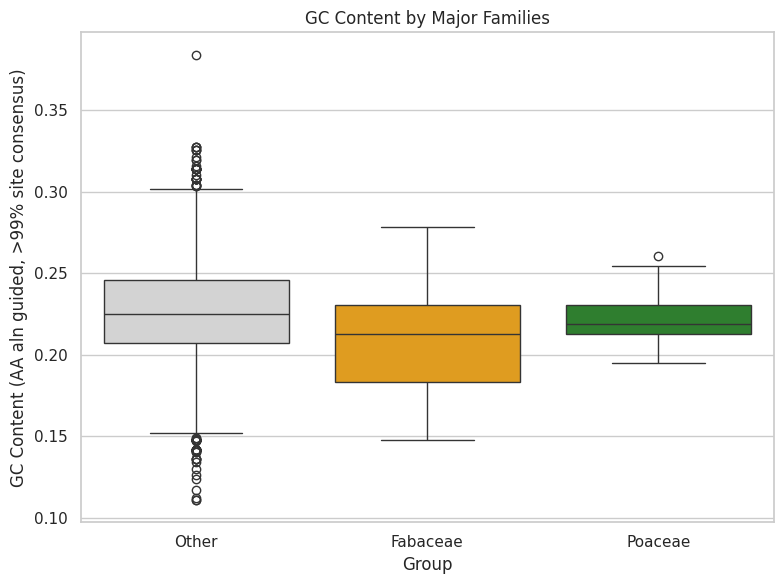

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a group column
def assign_group(taxonomy):
    if pd.isna(taxonomy):
        return "Other"
    elif "Poaceae" in taxonomy:
        return "Poaceae"
    elif "Fabaceae" in taxonomy:
        return "Fabaceae"
    else:
        return "Other"

merged_df["group"] = merged_df["Taxonomy"].apply(assign_group)

# plot boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_df, x="group", y="GC_content_99_consensus",
            palette={"Poaceae": "forestgreen", "Fabaceae": "orange", "Other": "lightgrey"})

plt.xlabel("Group")
plt.ylabel("GC Content (AA aln guided, >99% site consensus)")
plt.title("GC Content by Major Families")
plt.tight_layout()
plt.show()


In [45]:
group_counts = merged_df.groupby("group").size()
for group, count in group_counts.items():
    print(f"{group}: N = {count}")

Fabaceae: N = 690
Other: N = 13508
Poaceae: N = 1057


/tmp/ipykernel_89897/3129616419.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x="plot_group", y="GC_content_99_consensus",


<Figure size 1000x600 with 0 Axes>

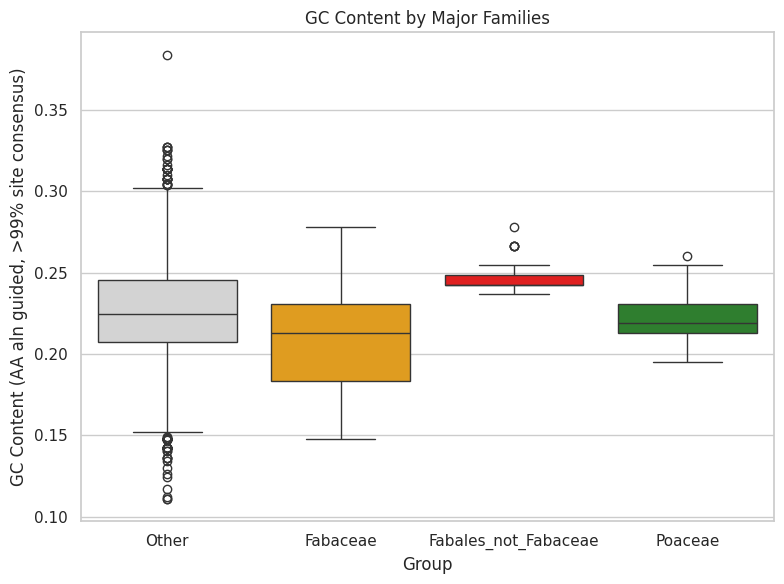

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# define groups
def assign_group_extended(taxonomy):
    if pd.isna(taxonomy):
        return "Other"
    elif "Poaceae" in taxonomy:
        return "Poaceae"
    elif "Fabaceae" in taxonomy:
        return "Fabaceae"
    elif "Fabales" in taxonomy:
        return "Fabales_not_Fabaceae"
    else:
        return "Other"

merged_df["plot_group"] = merged_df["Taxonomy"].apply(assign_group_extended)

# make histogram
plt.figure(figsize=(10, 6))

groups = ["Other", "Poaceae", "Fabaceae", "Fabales_not_Fabaceae"]
colors = ["lightgrey", "forestgreen", "orange", "red"]
# plot boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=merged_df, x="plot_group", y="GC_content_99_consensus",
            palette=dict(zip(groups, colors)))

plt.xlabel("Group")
plt.ylabel("GC Content (AA aln guided, >99% site consensus)")
plt.title("GC Content by Major Families")
plt.tight_layout()
plt.show()




In [56]:
group_counts = merged_df.groupby("plot_group").size()
for group, count in group_counts.items():
    print(f"{group}: N = {count}")

Fabaceae: N = 690
Fabales_not_Fabaceae: N = 39
Other: N = 13469
Poaceae: N = 1057


In [51]:
#what are th organisms in fabales_not_fabaceae?
fabales_not_fabaceae = merged_df[merged_df["plot_group"] == "Fabales_not_Fabaceae"]
print("Organisms in Fabales not Fabaceae:")
for taxon in fabales_not_fabaceae["Organism"].unique():
    print(taxon)

Organisms in Fabales not Fabaceae:
Polygala glomerata
Monnina fosbergii
Asemeia violacea
Monnina pycnophylla
Monnina conferta
Monnina denticulata
Monnina loxensis
Monnina sandemanii
Hebecarpa caracasana
Monnina carmelensis
Monnina bonplandiana
Monnina equatoriensis
Monnina sodiroana
Monnina pichinchensis
Polygala crotalarioides
Suriana maritima
Monnina cestrifolia
Monnina confusa
Monnina crassifolia
Monnina fastigiata
Monnina herbacea
Monnina hirta
Monnina leptostachya
Monnina marginata
Monnina phillyreoides
Monnina pterocarpa
Monnina salicifolia
Monnina splendens
Monnina subspeciosa
Polygala arillata
Polygala fallax
Polygala hongkongensis
Polygala japonica
Polygala karensium
Polygala sibirica
Polygala subopposita
Polygala tatarinowii
Polygala tenuifolia
Salomonia cantoniensis


/tmp/ipykernel_89897/3710668733.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


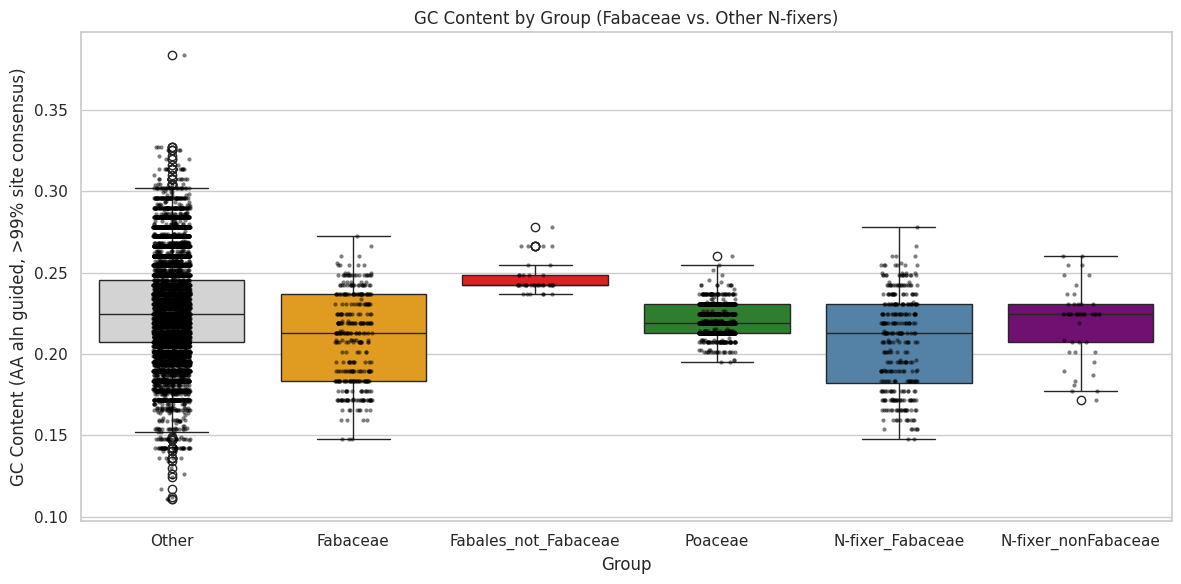

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def assign_group_with_fixation(row):
    # highest priority: fixation label
    if pd.notna(row["FixationLabel"]) and row["FixationLabel"] == "Yes":
        if "Fabaceae" in str(row["Taxonomy"]):
            return "N-fixer_Fabaceae"
        else:
            return "N-fixer_nonFabaceae"
    
    # otherwise fall back to taxonomy
    taxonomy = row["Taxonomy"]
    if pd.isna(taxonomy):
        return "Other"
    elif "Poaceae" in taxonomy:
        return "Poaceae"
    elif "Fabaceae" in taxonomy:
        return "Fabaceae"
    elif "Fabales" in taxonomy:
        return "Fabales_not_Fabaceae"
    else:
        return "Other"

merged_df["plot_group"] = merged_df.apply(assign_group_with_fixation, axis=1)

# define plotting order and colors
groups = [
    "Other", 
    "Poaceae", 
    "Fabaceae", 
    "Fabales_not_Fabaceae", 
    "N-fixer_Fabaceae", 
    "N-fixer_nonFabaceae"
]
colors = [
    "lightgrey", 
    "forestgreen", 
    "orange", 
    "red", 
    "steelblue", 
    "purple"
]

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_df[merged_df["plot_group"].isin(groups)],
    x="plot_group",
    y="GC_content_99_consensus",
    palette=dict(zip(groups, colors))
)

# overlay points
sns.stripplot(
    data=merged_df[merged_df["plot_group"].isin(groups)],
    x="plot_group",
    y="GC_content_99_consensus",
    color="black", size=3, jitter=True, alpha=0.5
)

plt.xlabel("Group")
plt.ylabel("GC Content (AA aln guided, >99% site consensus)")
plt.title("GC Content by Group (Fabaceae vs. Other N-fixers)")
plt.tight_layout()
plt.show()




/tmp/ipykernel_89897/2624904474.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


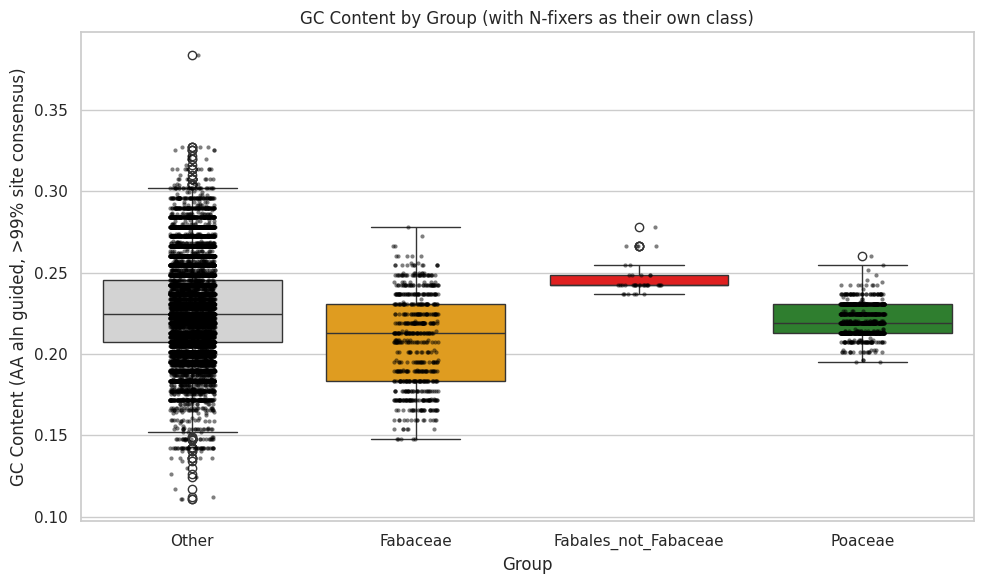

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# start with the taxonomic grouping
def assign_group_extended(taxonomy):
    if pd.isna(taxonomy):
        return "Other"
    elif "Poaceae" in taxonomy:
        return "Poaceae"
    elif "Fabaceae" in taxonomy:
        return "Fabaceae"
    elif "Fabales" in taxonomy:
        return "Fabales_not_Fabaceae"
    else:
        return "Other"

merged_df["plot_group"] = merged_df["Taxonomy"].apply(assign_group_extended)

# overwrite with "N-fixer" if FixationLabel is True
merged_df.loc[merged_df["FixationLabel"] == True, "plot_group"] = "N-fixer"

# define plotting order + colors
groups = ["Other", "Poaceae", "Fabaceae", "Fabales_not_Fabaceae", "N-fixer"]
colors = ["lightgrey", "forestgreen", "orange", "red", "steelblue"]

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=merged_df[merged_df["plot_group"].isin(groups)],
    x="plot_group", 
    y="GC_content_99_consensus",
    palette=dict(zip(groups, colors))
)

# add jitter
sns.stripplot(
    data=merged_df[merged_df["plot_group"].isin(groups)],
    x="plot_group", 
    y="GC_content_99_consensus",
    color="black", size=3, jitter=True, alpha=0.5
)

plt.xlabel("Group")
plt.ylabel("GC Content (AA aln guided, >99% site consensus)")
plt.title("GC Content by Group (with N-fixers as their own class)")
plt.tight_layout()
plt.show()
